# Adjusted Cohort Graduation Rate

In [2]:
import sys,os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from swampy import structshape as ss
import boto3
import shelve

In [3]:
def make_raw_gr_frame(year):
    """Create raw graduation rate dataframe for a given year from S3. It is 'raw' because
    no modifications are done and it is cached locally as-is."""
    conn = boto3.client('s3')

    # Graduation rate raw data filenames on S3
    year_to_loc = {2018 : "grad_rate/acgr-sch-sy2018-19-wide.csv",
        2017 : "grad_rate/acgr-sch-sy2017-18.csv",
        2016 : "grad_rate/acgr-sch-sy2016-17.csv", 
        2015 : "grad_rate/acgr-sch-sy2015-16.csv",
        2014 : "grad_rate/acgr-release2-sch-sy2014-15.csv",
        2013 : "grad_rate/acgr-sch-sy2013-14.csv",
        2012 : "grad_rate/acgr-sch-sy2012-13.csv",
        2011 : "grad_rate/acgr-sch-sy2011-12.csv",
        2010 : "grad_rate/acgr-sch-sy2010-11.csv"}
    
    # Verify input parameter is valid
    if year not in list(range(2010, 2019)):
        raise ValueError("input parameter {} is out of range.".format(year))

    # Local storage (cache) for the raw data so that iteration time is faster.
    shelf = shelve.open("gr_dfs")

    df = pd.DataFrame()
    shelf_key = str(year)

    if shelf_key in shelf:
        df = shelf[shelf_key]
    else:
        tmp_file_name = 'curr_file.csv.bak' 
        conn.download_file('edu-data-bucket',year_to_loc[year],tmp_file_name)

        df = pd.read_csv(tmp_file_name)
        shelf[shelf_key] = df

        if os.path.exists(tmp_file_name):
            os.remove(tmp_file_name)

    # Shelve teardown
    shelf.close()
    return df

def year_string(y: int):
    """Input an integer year and get a range that matches the column suffixes in the raw data.
    e.g. 2011 => 1112 and 2018 => 1819."""
    return str(y)[-2:] + str(int(str(y)[-2:]) + 1)

In [4]:
dfs = [make_raw_gr_frame(year=y) for y in range(2010, 2019)]
years = [year_string(y) for y in range(2010, 2019)]

# Many of the column names have the school year in them, which presents a challenge for combining all the years
# into one large dataframe.


shape_data = [(school_year, df.shape) for school_year, df in zip(years, dfs)]
shape = pd.DataFrame(shape_data, columns=('school_year', 'shape'))
shape

# Inspect features that are present in some but not common to all.
# Start by removing the years from the column names.
# cols_wo_year => Column names without the year
cols_wo_year = [list(map(lambda x: x.replace(y, ""), df.columns))
                for y, df in zip(years, dfs)]
print(set(cols_wo_year[3]) - set(cols_wo_year[0]))
print(set(cols_wo_year[6]) - set(cols_wo_year[0]))
print(set(cols_wo_year[7]) - set(cols_wo_year[0]))
print(set(cols_wo_year[8]) - set(cols_wo_year[0]))

{'INSERT_DATE'}
{'ST_SCHID', 'ST_LEAID'}
{'HOM_RATE_', 'FCS_RATE_', 'HOM_COHORT_', 'ST_SCHID', 'ST_LEAID', 'FCS_COHORT_'}
{'HOM_RATE_', 'FCS_RATE_', 'HOM_COHORT_', 'ST_SCHID', 'ST_LEAID', 'FCS_COHORT_'}


In [5]:
# INSERT_DATE refers to when the data was inserted and is not relevant for our study.
dfs[3].drop(['INSERT_DATE'], axis=1, inplace=True)
# ST_SCHID and ST_LEAID are values assigned by the state which are not found in the other years. From the data, it looks like maybe these
# started being assigned in 2016. If we need another geographical grouping mechanism in the future we can look into it.
dfs[6].drop(['ST_LEAID', 'ST_SCHID'], axis=1, inplace=True)
# HOM_COHORT and FCS_COHORT refer to the subpopulation of homeless and foster care students, which was not tracked before school year 2017-2018
idx7_sr = shape.school_year[7]
idx8_sr = shape.school_year[8]
dfs[7].drop(['ST_LEAID', 'ST_SCHID', 'FCS_RATE_'+idx7_sr, 'FCS_COHORT_'+idx7_sr,
            'HOM_RATE_'+idx7_sr, 'HOM_COHORT_'+idx7_sr], axis=1, inplace=True)
dfs[8].drop(['ST_LEAID', 'ST_SCHID', 'FCS_RATE_'+idx8_sr, 'FCS_COHORT_'+idx8_sr,
            'HOM_RATE_'+idx8_sr, 'HOM_COHORT_'+idx8_sr], axis=1, inplace=True)

In [6]:
# Create large df of all the years
cols_wo_school_year = [list(map(lambda x: x.replace(y, ""), df.columns))
                       for y, df in zip(years, dfs)]
for num1, num2 in zip(range(0, 8), range(1, 9)):
    assert cols_wo_school_year[num1] == cols_wo_school_year[num2]

big_df = pd.DataFrame()
print("big_df_columns", big_df.columns)
for idx, df in enumerate(dfs):
    df.columns = cols_wo_school_year[0]
    df['Year'] = list(range(2010,2019))[idx]
    # reorder columns to be how we want
    df = df[['Year']+cols_wo_school_year[0]]
    big_df = pd.concat([big_df, df], axis=0)


big_df.shape, big_df.head(n=3)

big_df_columns Index([], dtype='object')


((201567, 28),
    Year    STNAM  FIPST   LEAID             LEANM      NCESSCH  \
 0  2010  ALABAMA      1  100005  Albertville City  10000500871   
 1  2010  ALABAMA      1  100006   Marshall County  10000600872   
 2  2010  ALABAMA      1  100006   Marshall County  10000600878   
 
                  SCHNAM ALL_COHORT_ ALL_RATE_ MAM_COHORT_  ... MTR_RATE_  \
 0  Albertville High Sch         252        80           .  ...         .   
 1            Asbury Sch          57     70-79           .  ...         .   
 2      Douglas High Sch         125     65-69           2  ...         .   
 
   MWH_COHORT_ MWH_RATE_ CWD_COHORT_ CWD_RATE_ ECD_COHORT_ ECD_RATE_  \
 0         184     80-84           3        PS         121     65-69   
 1          48     70-79           7      GE50          31     60-69   
 2         105     70-74          13      GE50          92     60-64   
 
   LEP_COHORT_ LEP_RATE_ DATE_CUR  
 0          10      LT50  03OCT15  
 1           3        PS  03OCT15  
 2     

In [7]:
# Missingness
big_df.isnull().sum()

##### Why doesn’t the summation of the major racial and ethnic groups equal the “ALL” student count?
# * Due to flexibilities with states’ implementation of the Elementary and Secondary Education Act,
#   there may be instances where not all possible groupings of racial/ethnic identification are reported
#   as individual subgroups. Therefore, some information may be missing and these counts by major racial
#   and ethnic group will not include every student; however any students not included within an individual
#   major racial and ethnic group would be included in the “ALL” student count.
# #### Why are the major racial and ethnic groups reported differently by states?
# * Under the ESEA, a State educational agency (SEA) has the flexibility to determine the major racial/ethnic
#   groups it will use for reporting on the data included in its assessment and accountability system.  The
#   subgroups that an SEA uses are approved through its Accountability Workbook (the most recent copy of each
#   state’s workbook can be found here:  http://www2.ed.gov/admins/lead/account/stateplans03/index.html).
#   As a result, there is some variation in how SEAs report data by race and ethnicity. 

# Drop population subgroup columns
cols_to_keep = ['Year', 'STNAM', 'FIPST', 'LEAID', 'LEANM',
                'NCESSCH', 'SCHNAM', 'ALL_COHORT_', 'ALL_RATE_']
big_df = big_df[cols_to_keep]


# Drop rows where ALL_COHORT_ == '.'
instances_after_drop = len(big_df) - 2913
# Reindex the dataframe because their are duplicate indexes
big_df.index = list(range(len(big_df)))
big_df.drop(big_df[big_df.ALL_COHORT_ == '.'].index, axis=0, inplace=True)
assert len(big_df) == instances_after_drop
print("Number of instances after this drop", len(big_df))
# Can convert ALL_COHORT_ column to numeric now
big_df.loc[:,'ALL_COHORT_'] = np.int64(big_df.ALL_COHORT_.values)
big_df.dtypes

# Drop rows where ALL_RATE_ == 'PS'. About 1400 schools per year are dropped.
print("Dropping", len(big_df[big_df.ALL_RATE_ == 'PS']))
big_df.drop(big_df[big_df.ALL_RATE_ == 'PS'].index, axis=0, inplace=True)
print("Number of instances after this drop", len(big_df))




Number of instances after this drop 198654
Dropping 12507
Number of instances after this drop 186147


In [8]:
# Several columns are of object type, which means that either text or Nan values are present.
def print_object_column_info(df):
    """
    Print column data types and the number of object columns.
    """
    print(big_df.dtypes, "{} object columns present". format(
        len(big_df.select_dtypes(include=object).count())))


print_object_column_info(big_df)


Year            int64
STNAM          object
FIPST           int64
LEAID           int64
LEANM          object
NCESSCH         int64
SCHNAM         object
ALL_COHORT_     int64
ALL_RATE_      object
dtype: object 4 object columns present


In [9]:
# Convert year feature to numeric
big_df.loc[:, 'Year'] = np.int64(big_df.Year)

# THe ALL_RATE_ column has numbers given as ranges, numbers with GE,LE,LT,GT prefixes, and also 'PS'.
# The codebook explains that these are to conceal specifics when it would give us the ability to identify individual students. The 'PS' specifically means that the cohort had 5 or fewer students in it.
# Drop the ALL_RATE_ rows that have 'PS' and convert the rest to the average meaning of the term. E.g. GT50 => 75, LT50 => 25, 88-92 => 90.

# Helper functions to convert ranges given in ALL_RATE_ column to a trivially convertible string 
def conv_range_to_numeric_string(t: str):
    """Take in a numeric range given as a string, e.g. "10-20" and return the midpoint as a string."""
    vals = t.split("-")
    if len(vals) == 2:
        val1, val2 = float(vals[0]), float(vals[1])
        new_val = val1 / 2.0 + val2 / 2.0
        return str(new_val)
    else:
        # If a range with a dash in it is not found, return original string unchanged.
        return t

assert conv_range_to_numeric_string('95-95') == '95.0'
assert conv_range_to_numeric_string('105-110') == '107.5'
assert conv_range_to_numeric_string('90') == '90'

def strip_prefixed_string(t: str):
    """
    Convert prefixed numbers to a string of a number in the midpoint of their range 
    """
    if t.startswith('GT'):
        t = t.removeprefix('GT')
        t = float(t)
        t = sum([t, 100.0])/2.0
        return str(t)
    elif t.startswith('GE'):
        t = t.removeprefix('GE')
        t = float(t)
        t = sum([t, 100.0])/2.0
        return str(t)
    elif t.startswith('LT'):
        t = t.removeprefix('LT')
        t = float(t)
        t = sum([t, 0])/2.0
        return str(t)
    elif t.startswith('LE'):
        t = t.removeprefix('LE')
        t = float(t)
        t = sum([t, 0])/2.0
        return str(t)
    # If one of the prefixes is not found, return original string unchanged
    return t

assert strip_prefixed_string('GE50') == '75.0'
assert strip_prefixed_string('GT50') == '75.0'
assert strip_prefixed_string('LE90') == '45.0'
assert strip_prefixed_string('LT90') == '45.0'
assert strip_prefixed_string('95-95') == '95-95'

# Run the above functions on the series to produce a float64 series
big_df.loc[:, 'ALL_RATE_'] = big_df.ALL_RATE_.map(strip_prefixed_string, na_action='ignore')
big_df.loc[:, 'ALL_RATE_'] = big_df.ALL_RATE_.map(conv_range_to_numeric_string, na_action='ignore')
big_df.loc[:, 'ALL_RATE_'] = pd.to_numeric(big_df.ALL_RATE_.tolist()) 


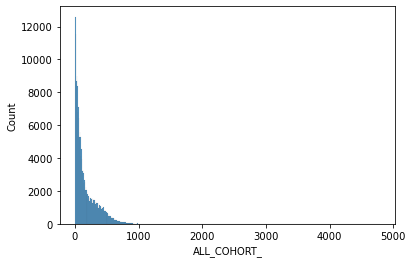

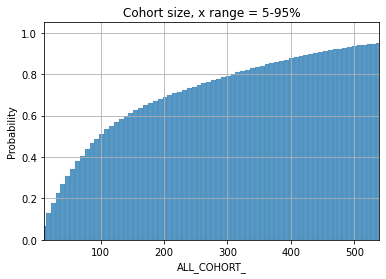

In [10]:
large_school_indexes = big_df.ALL_COHORT_ > 5000
big_df.loc[large_school_indexes,:]

# Schools are found with >20,000 students in a cohort. Based on google search, the graduating classes are closer to 100-200 than the extremely large sizes reported.
# We drop these schools since they are called into question. Note that we could impute them with the mean school size.

big_df.drop(big_df[large_school_indexes].index,axis=0,inplace=True)
sns.histplot(big_df.ALL_COHORT_,)
plt.show()
big_df.ALL_COHORT_.describe()

sns.histplot(big_df.ALL_COHORT_,cumulative=True,stat='probability')

xlimits = np.percentile(big_df.ALL_COHORT_,[5,95])
plt.title("Cohort size, x range = 5-95%")
plt.xlim(xlimits)
plt.grid(visible=True)

In [11]:
# Rename BUREAU OF INDIAN AFFAIRS to BUREAU OF INDIAN EDUCATION
indian_affairs_rows = big_df.query("STNAM.str.contains('INDIAN AFFAIRS')").index
big_df.loc[indian_affairs_rows,'STNAM'] = 'BUREAU OF INDIAN EDUCATION' 

In [12]:
big_df.to_csv('grad_rate_intermediate.csv.bak',index=False)

# School Directory Dataset

In [13]:
conn = boto3.client('s3')
local_dir_filename = 'directory_all.csv.bak'
if not os.path.exists('./' + local_dir_filename):
    conn.download_file(
        'edu-data-bucket', 'directory/schools_ccd_directory.csv', local_dir_filename)

df0 = pd.read_csv(local_dir_filename, low_memory=False)

df0.shape


(3381565, 52)

In [14]:
# Observations
#  There are many years and schools in this dataset that are not in the graduation rate dataset
# * Ncessch and ncessch_num appear to be duplicates
# * Features shared with the Adjusted Cohort dataset are
#     * ncessch
#     * school_name
#     * leaid
#     * lea_name
#     * state_location
#     * fips

# Subset to our years of interest
years = list(range(2010, 2019))
our_years = df0.query('year in @years')
pd.set_option('display.max_columns', 99)
our_years.head(n=3)

# Remove uninteresting columns
# Uninteresting because duplicate: 'school_id', 'ncessch_num', 'leaid','lea_name','school_name', 'state_location','fips', 'phone_string'
# Verify ncessch == ncescch_num since we will merge on it later.
# Leave school district identifier for verification that the merge worked later.
assert all(our_years.ncessch == our_years.ncessch_num)
our_years.drop(['ncessch_num', 'school_id', 'lea_name',
               'school_name', 'state_location', 'fips','school_status', 'longitude','phone','city_location','street_location','street_mailing', 'state_leaid','state_leg_district_lower','state_leg_district_upper','congress_district_id','csa','cbsa','direct_certification','title_i_schoolwide', 'lunch_program','seasch','city_mailing','state_mailing','elem_cedp','middle_cedp','high_cedp','shared_time','bureau_indian_education'], axis=1, inplace=True)

/tmp/ipykernel_460836/3042575937.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_years.drop(['ncessch_num', 'school_id', 'lea_name',


In [15]:
# Missingness

# Impute -1,-2,-3 missing values to nans
# Find strings equal to -1,-2, or -3
special_vals = pd.DataFrame([(our_years.select_dtypes(include=[object]) == "-1").sum(), (our_years.select_dtypes(
    include=[object]) == "-2").sum(), (our_years.select_dtypes(include=[object]) == "-3").sum()])
special_vals.index = ["-1", "-2", "-3"]
special_vals

special_vals = pd.DataFrame([(our_years.select_dtypes(include=[np.number]) == -1).sum(), (our_years.select_dtypes(
    include=[np.number]) == -2).sum(), (our_years.select_dtypes(include=[np.number]) == -3).sum()])
special_vals.index = ["-1", "-2", "-3"]
special_vals

str_cols = our_years.select_dtypes(include=object).columns.tolist()
num_cols = our_years.select_dtypes(include=np.number).columns.tolist()
str_col_special_nans = (our_years[str_cols] == "-1") | (our_years[str_cols] == "-2") 
num_col_special_nans = (our_years[num_cols] < 0)
assert "highest_grade_offered" in num_cols

our_years.loc[:,str_cols] = our_years[str_cols].where(~str_col_special_nans,other=np.nan)
our_years.loc[:,num_cols] = our_years[num_cols].where(~num_col_special_nans,other=np.nan)

our_years.highest_grade_offered.value_counts()
non_high_schools = our_years.query('highest_grade_offered <= 9')
our_years.drop(non_high_schools.index,axis=0,inplace=True)



/tmp/ipykernel_460836/1767996848.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_years.loc[:,str_cols] = our_years[str_cols].where(~str_col_special_nans,other=np.nan)
/tmp/ipykernel_460836/1767996848.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_years.loc[:,num_cols] = our_years[num_cols].where(~num_col_special_nans,other=np.nan)
/tmp/ipykernel_460836/1767996848.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

In [16]:
# Meaningful Missingness
# Use school directory cookbook to make decisions are removing columns that we are uncertain about.

our_years.virtual.replace(np.nan,0,inplace=True)
assert our_years.virtual.isnull().sum() == 0

/tmp/ipykernel_460836/127421010.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_years.virtual.replace(np.nan,0,inplace=True)


<AxesSubplot:>

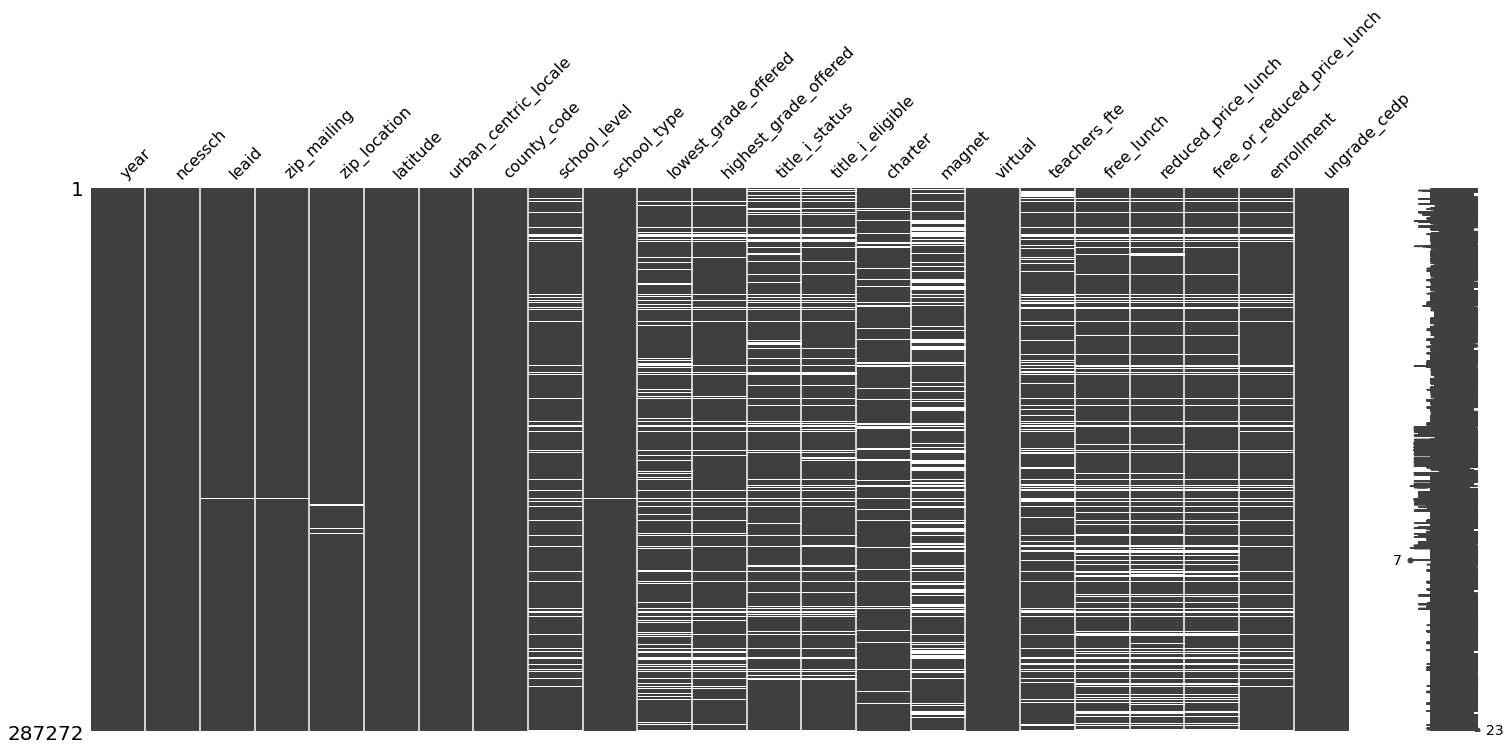

In [17]:
import missingno
missingno.matrix(our_years)

In [18]:
# Examine reduced_price_lunch to see how similar it is to free_or_reduced_price_lunch
np.subtract(our_years.free_lunch,our_years.free_or_reduced_price_lunch)
# It looks like there is some additional information in both columns so we'll keep them both.

2252826    NaN
2252827    NaN
2252828    NaN
2252829    NaN
2252830    NaN
          ... 
3178199    0.0
3178201    0.0
3178203    NaN
3178204    0.0
3178210    NaN
Length: 287272, dtype: float64

In [19]:
# Drop all rows with a missing feature, the simplest way to get rid of our nans
our_years.dropna(inplace=True)
our_years = our_years.convert_dtypes(convert_string=False)

/tmp/ipykernel_460836/3339393172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_years.dropna(inplace=True)


In [20]:
# Examine features that are still objects 
pd.DataFrame(our_years.dtypes).T

,year,ncessch,leaid,zip_mailing,zip_location,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp
0,Int64,Int64,Int64,object,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64


<AxesSubplot:>

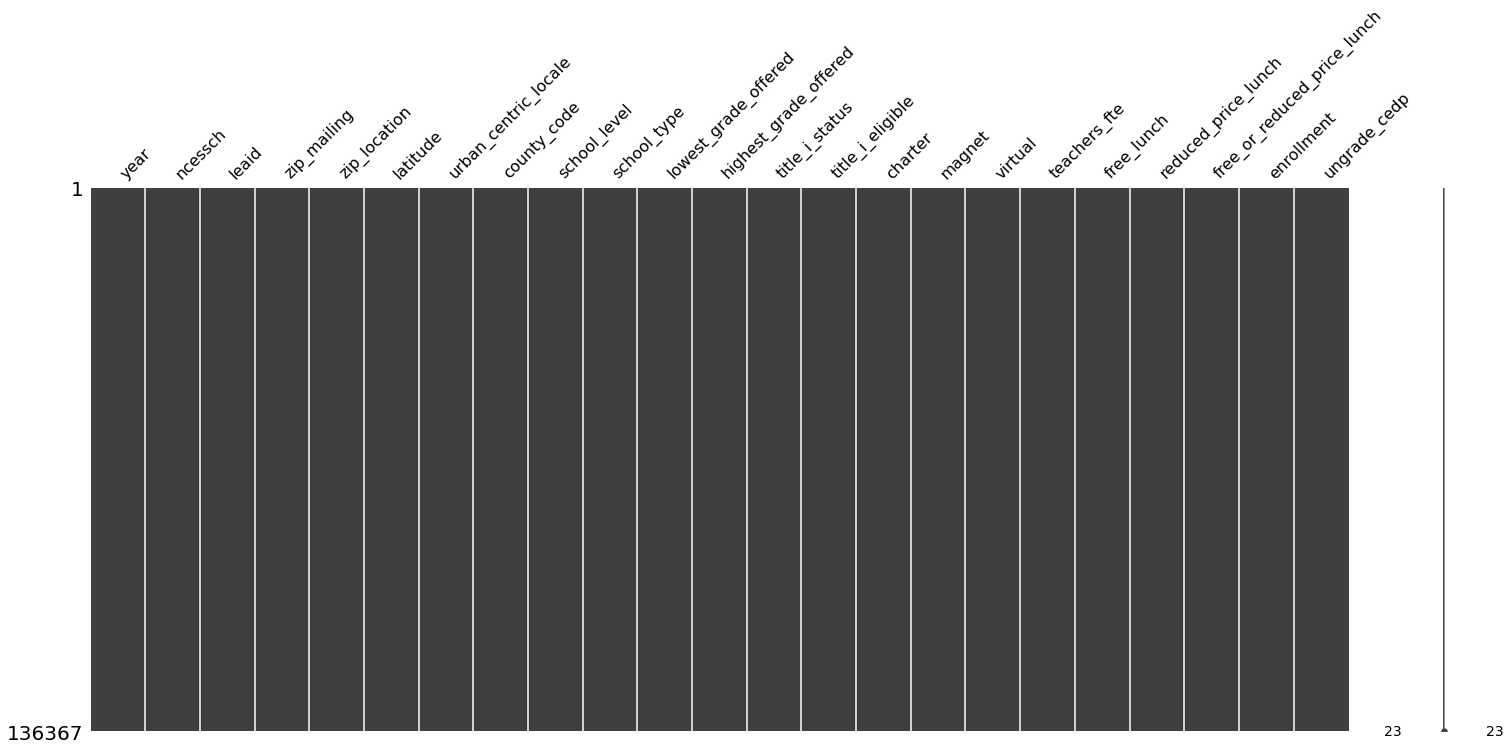

In [21]:
our_years.shape
missingno.matrix(our_years)

In [22]:
# Noting down how many instances we'll have when we trim off 2010 and 2011
our_years.query('year >= 2012').shape

(109989, 23)

In [23]:
our_years.info()
our_years.to_csv('directory_intermediate_dataframe.csv.bak',index=False)
our_years.head(n=3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136367 entries, 2254443 to 3176837
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   year                         136367 non-null  Int64  
 1   ncessch                      136367 non-null  Int64  
 2   leaid                        136367 non-null  Int64  
 3   zip_mailing                  136367 non-null  object 
 4   zip_location                 136367 non-null  Int64  
 5   latitude                     136367 non-null  Float64
 6   urban_centric_locale         136367 non-null  Int64  
 7   county_code                  136367 non-null  Int64  
 8   school_level                 136367 non-null  Int64  
 9   school_type                  136367 non-null  Int64  
 10  lowest_grade_offered         136367 non-null  Int64  
 11  highest_grade_offered        136367 non-null  Int64  
 12  title_i_status               136367 non-null  Int64

,year,ncessch,leaid,zip_mailing,zip_location,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp
2254443,2010,20000100208,200001,99559,99559,60.802525,41,2050,4,1,6,12,3,1,0,0,0,31.5,170,14,184,482,0
2254450,2010,20000100215,200001,99651,99651,59.0103,43,2050,4,1,0,12,3,1,0,0,0,1.2,9,0,9,12,0
2254451,2010,20000100318,200001,99559,99559,60.79596,33,2050,3,4,8,12,3,1,0,0,0,4.0,33,1,34,42,0


# Math and Reading / Language Arts Assessment Participation

In [24]:
# @TODO for completeness. Upload assessment participation for math and rla, the raw data, to S3
# Ingest from S3 
conn = boto3.client('s3')
local_dir_filename = 'math_rla_percent_participation_prefiltered.csv.bak'
if not os.path.exists('./' + local_dir_filename):
    conn.download_file(
        'edu-data-bucket', 'percent_participation/math_rla_percent_participation_prefiltered.csv', local_dir_filename)


perc_part = pd.read_csv(local_dir_filename, low_memory=False)
perc_part.shape, perc_part.info()

# Save intermediate file locally
perc_part.to_csv("percent_participation_intermediate.csv.bak",index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160367 entries, 0 to 160366
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Year           160367 non-null  int64 
 1   NCESSCH        160367 non-null  int64 
 2   Math_Pct_Part  160367 non-null  object
 3   Rla_Pct_Part   160367 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.9+ MB


# Merge datasets and output for exploration and modeling 

In [25]:
"""
Merge intermediate dataframes 
"""
gr = pd.read_csv('grad_rate_intermediate.csv.bak')
directory = pd.read_csv('directory_intermediate_dataframe.csv.bak')
perc_part = pd.read_csv('percent_participation_intermediate.csv.bak')

perc_part

,Year,NCESSCH,Math_Pct_Part,Rla_Pct_Part
0,2018,10000500871,98,98
1,2018,10000600872,GE95,GE95
2,2018,10000600878,GE95,GE95
3,2018,10000600883,GE95,GE95
4,2018,10000601585,GE95,GE95
...,...,...,...,...
160362,2017,560582000393,GE80,GE80
160363,2017,560583000335,GE99,GE99
160364,2017,560583000512,GE80,GE80
160365,2017,560609000401,GE90,GE90


In [26]:

merge0 = gr.merge(directory,how='left', left_on=('Year','NCESSCH'),right_on=('year','ncessch'))
merge1 = merge0.merge(perc_part,how='left',left_on=('Year','NCESSCH'),right_on=('Year','NCESSCH'))
merge1.head()

,Year,STNAM,FIPST,LEAID,LEANM,NCESSCH,SCHNAM,ALL_COHORT_,ALL_RATE_,year,ncessch,leaid,zip_mailing,zip_location,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part
0,2010,ALABAMA,1,100005,Albertville City,10000500871,Albertville High Sch,252,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,ALABAMA,1,100006,Marshall County,10000600872,Asbury Sch,57,74.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,ALABAMA,1,100006,Marshall County,10000600878,Douglas High Sch,125,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,ALABAMA,1,100006,Marshall County,10000600883,Kate D Smith DAR High Sch,121,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,ALABAMA,1,100006,Marshall County,10000601585,Brindlee Mt High Sch,94,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Drop redundant columns seen after merging
merge1.drop(['year','ncessch','leaid'],axis=1,inplace=True)
merge1.dropna(inplace=True)
merge1.shape

(89683, 31)

<AxesSubplot:>

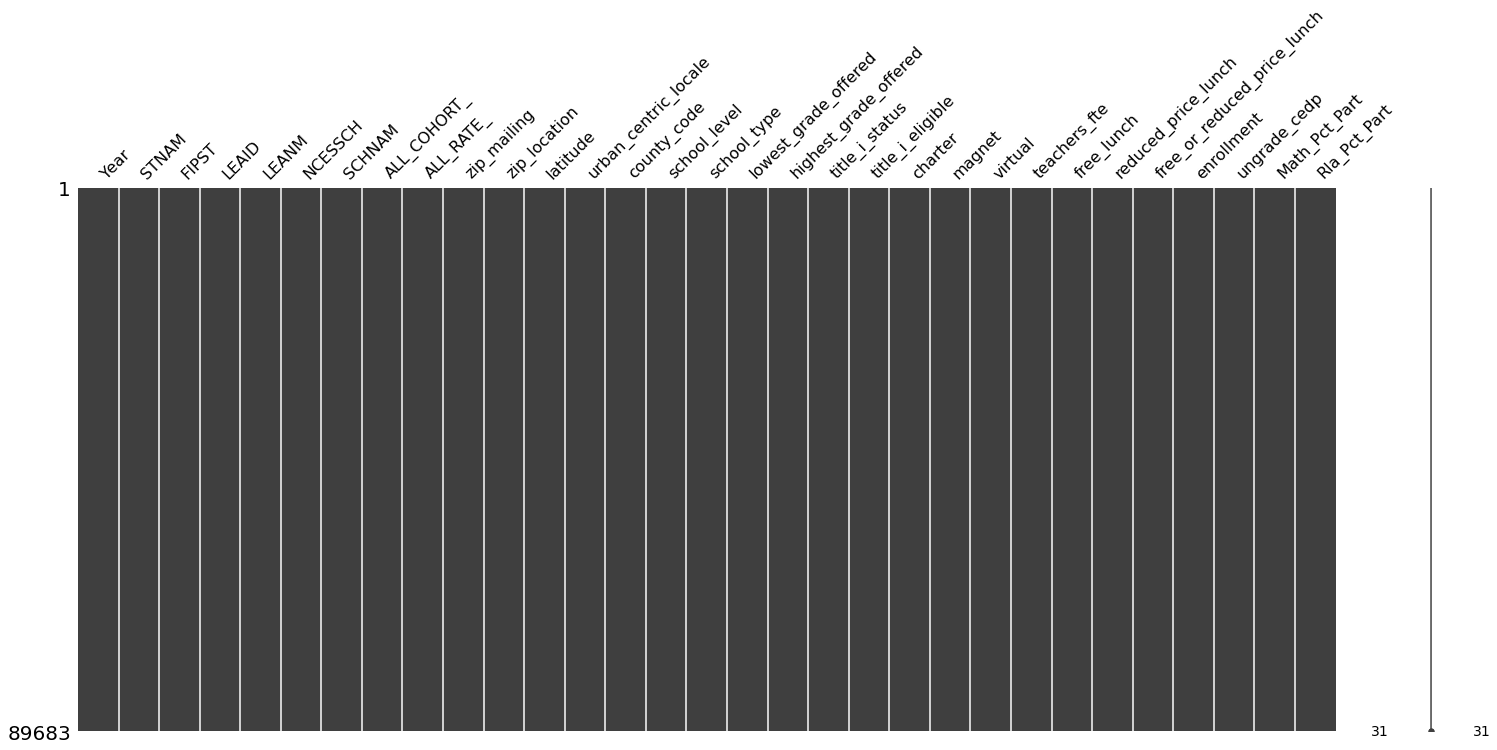

In [28]:
missingno.matrix(merge1)

In [29]:
# View column pairs with minimal positive correlation or above
pd.DataFrame((np.abs(merge1.corr()) > 0.3).sum()).T

,Year,FIPST,LEAID,NCESSCH,ALL_COHORT_,ALL_RATE_,zip_mailing,zip_location,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp
0,1,4,4,4,8,3,2,2,1,6,4,2,4,3,2,2,2,1,1,1,9,7,6,7,8,2


In [30]:
# Save out dataset A to disk
merge1.to_csv('mergeA.csv.bak',index=False)